<a href="https://colab.research.google.com/github/EskilRibbe11/Defensive-Distillation/blob/main/Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets


In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11383731.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 342866.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2712186.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3136922.24it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(9216, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    output = F.log_softmax(x, dim=1)
    return output

In [7]:
model = Net().to(device)

In [8]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [9]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [10]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.165389519938698 Val_Loss: 0.08612903829143993
Epoch: 2 Loss: 0.06557096226990346 Val_Loss: 0.06885571222286224
Epoch: 3 Loss: 0.051119227956390914 Val_Loss: 0.0671727996918206
Epoch: 4 Loss: 0.04152339403813177 Val_Loss: 0.057959941527557214
Epoch: 5 Loss: 0.03518516628884591 Val_Loss: 0.05723602497439316
Epoch: 6 Loss: 0.0330718568461884 Val_Loss: 0.05781608074085866
Epoch: 7 Loss: 0.029610500531423185 Val_Loss: 0.05850636613227991
Epoch: 8 Loss: 0.026174971875866013 Val_Loss: 0.05730060649728735
Epoch: 9 Loss: 0.024442615868773433 Val_Loss: 0.057759439352880804
Epoch: 10 Loss: 0.017616203918381073 Val_Loss: 0.05287598105171594


In [11]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out


In [12]:
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

In [13]:
gradient = data_grad[0][0]

In [14]:
Data1 = []
for k1, k2 in test_loader:
  Data1.append(k1)

In [15]:
example1 = Data1[0][0][0]
example1

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [17]:
small_attack = fgsm_attack(example1, 0.01, gradient)
medium_attack = fgsm_attack(example1, 0.1, gradient)
big_attack = fgsm_attack(example1, 0.3, gradient)
attacks = [example1, small_attack, medium_attack, big_attack]

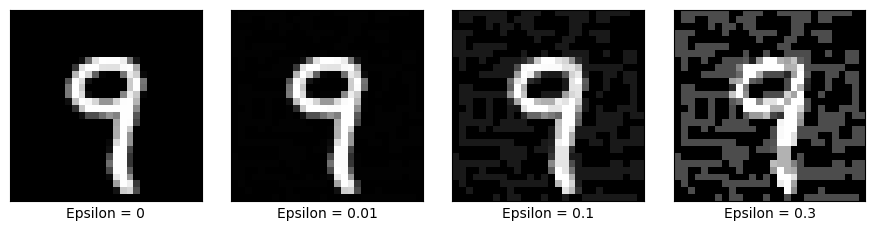

In [22]:
plt.figure(figsize = (9,9))
epsilons = [0, 0.01 ,0.1,0.3]
for i in range(1,5):
  plt.subplot(4,4,i)
  plt.xticks([], [])
  plt.yticks([], [])
  plt.xlabel("Epsilon = {}".format(epsilons[i-1]))
  plt.imshow(attacks[i-1], cmap = "gray")
plt.tight_layout()
plt.show()